<a href="https://colab.research.google.com/github/tc3oliver/StratLabFreq/blob/dev/MACD_Divergence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/StratLabFreq')
os.listdir()

['MACD_Divergence_Analysis.ipynb', 'data', 'TaipeiSansTCBeta-Regular.ttf']

In [2]:
import pandas as pd

In [3]:
dataframe = pd.read_json('./data/BTC_USDT-5m.json')
dataframe.columns=['date', 'open' , 'high', 'low', 'close', 'volume' ]
dataframe['date']=(pd.to_datetime(dataframe['date'],unit='ms'))
dataframe

,date,open,high,low,close,volume
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000
2,2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000
3,2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666
4,2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570
...,...,...,...,...,...,...
617219,2023-07-06 05:50:00,30549.80,30569.99,30549.80,30563.11,105.865190
617220,2023-07-06 05:55:00,30563.11,30593.64,30563.11,30582.51,71.446400
617221,2023-07-06 06:00:00,30582.50,30599.30,30573.33,30575.48,88.509370
617222,2023-07-06 06:05:00,30575.48,30575.48,30560.00,30570.04,58.483620


In [4]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 2.6 MB/s eta 0:00:00


In [5]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import statistics

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib
import talib.abstract as ta

# 下載字體
# !wget https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download -O TaipeiSansTCBeta-Regular.ttf

# 註冊字體
# font_path = 'TaipeiSansTCBeta-Regular.ttf'
# prop = fm.FontProperties(fname=font_path)
# 設定 matplotlib 字體
# mpl.rcParams['font.family'] = prop.get_name()
# font={'font.family': prop.get_name()}
# style=mpf.make_mpf_style(base_mpf_style='default', rc=font)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4259    0  4259    0     0  12217      0 --:--:-- --:--:-- --:--:-- 12238
100  517k  100  517k    0     0   702k      0 --:--:-- --:--:-- --:--:-- 4039k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4283    0  4283    0     0  16902      0 --:--:-- --:--:-- --:--:-- 16928
100  392k  100  392k    0     0   649k      0 --:--:-- --:--:-- --:--:--  649k


In [6]:
import random

count = 40

def get_random_count_values_dataframe(df):
    if len(df) < count:
        raise ValueError("DataFrame 中的資料數量不足 40 個")

    start_index = random.randint(0, len(df) - count)

    selected_values = df.iloc[start_index : start_index + count]

    selected_df = pd.DataFrame(selected_values)

    return selected_df

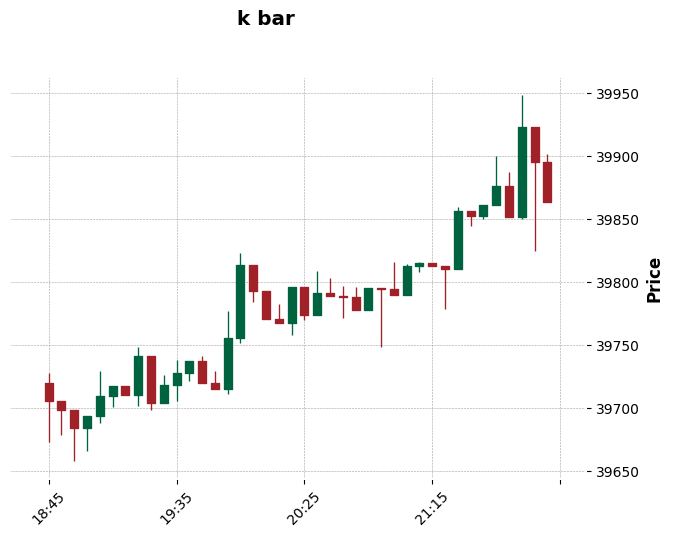

In [7]:
df = get_random_count_values_dataframe(dataframe)

# 將索引設定為 DatetimeIndex
df.set_index('date', inplace=True)

# 繪製 K 線圖
mpf.plot(df, type='candle', style='charles', title='k bar')

# 顯示圖表
plt.show()

In [8]:
macd = ta.MACD(dataframe, fastperiod=13, slowperiod=34)
dataframe['macdhist'] = macd['macdhist']

In [9]:
df = get_random_count_values_dataframe(dataframe)
df.head()

,date,open,high,low,close,volume,macdhist
356479,2021-01-11 03:45:00,34153.33,35250.00,34151.69,35200.84,1757.454631,-177.737755
356480,2021-01-11 03:50:00,35208.56,35555.27,34780.62,35449.28,1668.418511,-103.269561
356481,2021-01-11 03:55:00,35449.28,35704.91,35134.73,35438.23,1190.860751,-46.675549
356482,2021-01-11 04:00:00,35438.23,35999.95,35256.38,35666.61,1173.193032,12.315563
356483,2021-01-11 04:05:00,35661.41,35888.00,35500.00,35713.20,668.076653,57.722187


In [39]:
# 尋找三個峰值且這些波峰連續升高
def find_peak_sequence(data):
        peaks_index = []
        wave = []

        for i in range(len(data)):
            if i == len(data) - 1:
                break
            d = abs(data[i])
            if len(wave) == 0 or d > wave[-1]:
                wave.append(d)
            else:
                if len(wave) > 1:
                    peaks_index.append(i-1)
                wave = [d]

        if len(wave) > 0:
            peaks_index.append(i)

        highlighted_points = [(index, data[index]) for index in peaks_index]

        temp = highlighted_points[-1]


        if len(highlighted_points) < 3:
            return False, []

        highlighted_points = highlighted_points[:-1]

        highlighted_points = sorted(
            highlighted_points, key=lambda x: abs(x[1]), reverse=True)[:2]
        highlighted_points = sorted(
            highlighted_points, key=lambda x: x[0], reverse=False)
        highlighted_points.append(temp)

        if len(highlighted_points) >= 3:
          # 波峰的差異
          percentage_difference = abs(abs(highlighted_points[-1][1]) - abs(highlighted_points[-3][1])) / (abs(highlighted_points[-3][1])) * 100

          # 波峰的步數
          step = abs(highlighted_points[-3][0] - highlighted_points[-1][0])

          print(percentage_difference, step)

          if percentage_difference < 50:
            return False, []

          if step < count * 0.5:
            return False, []

          if abs(highlighted_points[-3][1]) > abs(highlighted_points[-2][1]) > abs(highlighted_points[-1][1]):
            return True, highlighted_points

        return False, []



In [40]:
# dataframe['is_high_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)
# 判斷高點持續提高
max_open_close = pd.Series.max(dataframe[['open', 'close']], axis=1)
dataframe['is_high_increase'] = max_open_close.rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)

# 空單條件檢查 零軸以上的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_short_wrapper(data):
            if data[-1] < 0:
                return False, []
            if abs(statistics.mean(x for x in data[-3:-1])) > abs(data[-1]):
                return False, []
            count = sum(1 for value in data if value > 0)
            if count < (len(data) / 2):
                return False, []
            return find_peak_sequence([n for n in data if n > 0])

934.6292663846666 12
28.645800698271756 29
19.76048896896953 5
31.65713260129576 16
44.02591032850376 21
81.97373688949423 29
108.9139698267811 27
54.6073737788888 13
29.702442560879632 17
32.14271721475752 18
46.192607289741986 14
33.041794578100536 14
65.51575227090349 16
60.05887585696485 17
72.78595553596392 16
281.4355710895676 10
72.4366790772024 15
84.94571024934503 16
77.39077107025832 16
65.57657281433119 13
74.31398783837588 24
23.339538868673973 6
19.120226190267402 25
37.572394306318884 19
286.10030485957896 12
72.78595553596392 16
60.05887585696485 17
95.89410385553624 9
70.31146856068196 23
83.76283320387411 22
88.80974760777622 30
82.61537890979874 28
                      date      open      high       low     close     volume  \
616677 2023-07-04 08:40:00  30967.99  30968.00  30950.19  30953.06   69.33448   
616678 2023-07-04 08:45:00  30953.06  30953.07  30912.23  30919.99  120.85170   
616679 2023-07-04 08:50:00  30919.99  30942.99  30916.00  30926.89  138.21896   
6

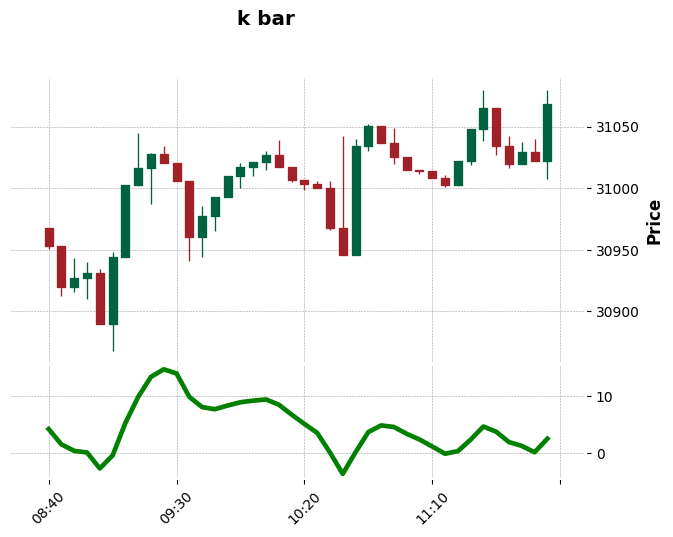

In [41]:
# 空單
while True:

  df = get_random_count_values_dataframe(dataframe[615796:])
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_short_wrapper(data)


  if isfind:
    if df['is_high_increase'].values.tolist()[-1]:
      print(df)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

In [42]:
# dataframe['is_low_decreasing'] = dataframe['low'].rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < max(x[:-1])), raw=True)

In [43]:
# 判斷低點持續降低
min_open_close = pd.Series.min(dataframe[['open', 'close']], axis=1)
dataframe['is_low_decreasing'] = min_open_close.rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < min(x[:-1])), raw=True)

# 多單條件檢查 零軸以下的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_logn_wrapper(data):
  if data[-1] > 0:
    return False, []
  count = sum(1 for value in data if value < 0)
  if count < (len(data) / 2):
      return False, []
  return find_peak_sequence(data)

38.84725289404039 16
90.00472884904352 21
59.10251669873403 32
[14.46907048764902, -4.16054411897737, -24.040442111868956, -36.86361289503091, -39.97235954026675, -49.437653367697365, -56.11473405313342, -65.00757497181917, -63.9192246286746, -48.89526395104316, -47.86124933419388, -39.618504582968676, -32.618665697640104, -30.05919844749547, -23.982463145855256, -16.093727206270884, -13.850990056081933, -8.427387276792317, -5.358492905713987, 9.137600433608362, 17.41996417971926, 29.496773826059314, 40.75459822732881, 46.25081785094167, 36.92644588361447, 23.62417924396819, 12.955156462458731, -3.2047274817343236, -13.977214665900238, -13.640330863609087, -8.982096960193331, -13.838972763455264, -23.973400218131736, -25.353542446254533, -27.508697893267694, -30.404506012920308, -31.7055700167542, -32.53123238795622, -31.40757885039862, -26.5864621186577]
[(7, -65.00757497181917), (23, 46.25081785094167), (39, -26.5864621186577)]


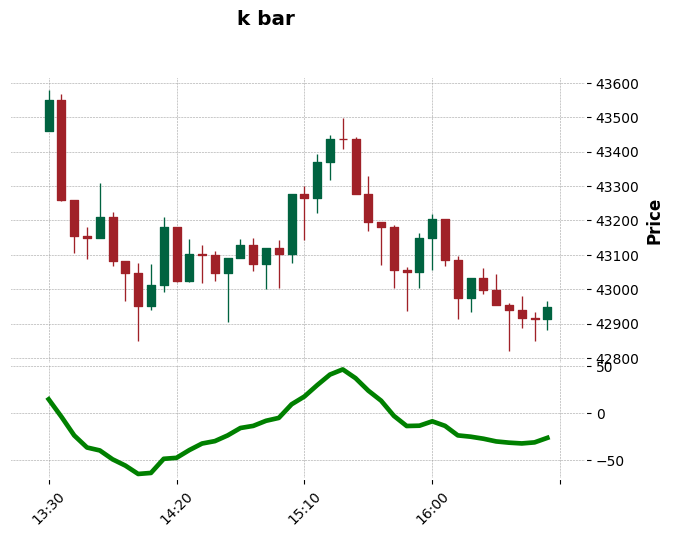

In [44]:
while True:

  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_logn_wrapper(data)


  if isfind:

    if df['is_low_decreasing'].values.tolist()[-1]:
      print(data)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break